In [1]:
import datetime
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Union

from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from bigbang.analysis.listserv import ListservMailList
#from bigbang.bigbang_io import pandas_dataframe_to_mbox

from tgpp.config.config import CONFIG
import tgpp.ingress.queries as Queries
from tgpp.ingress import organizations as ORGA

plt.style.use("./publication_jcap.mplstyle")

In [4]:
list(range(10, 100))

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

## Load data

In [2]:
# Load data on organisations in 3GPP

df_orgcat = ORGA.load_data()
df_orgcat = ORGA.expand_rows_with_multiple_entries(df_orgcat, column='email domain names')
df_orgcat = ORGA.assign_parent_nationality(df_orgcat)
df_orgcat = ORGA.remove_leading_and_trailing_whitespaces(df_orgcat)

# choose columns of interest
df_nation = df_orgcat[[
    "name",
    "nationality",
    "email domain names",
]]
# filter out all non-empty cells
df_nation = df_nation.dropna()

# choose columns of interest
df_seccat = df_orgcat[[
    "name",
    "category",
    "email domain names",
]]
# filter out all non-empty cells
df_seccat = df_seccat.dropna(subset=["category", "email domain names"])
df_seccat = ORGA.expand_rows_with_multiple_entries(df_seccat, column='category')

In [3]:
# Load Search-set (Sset)
mlist_name = "3GPP_TSG_SA_WG3"

mlist = ListservMailList.from_mbox(
    name=mlist_name,
    filepath=CONFIG.folder_search_set + f"{mlist_name}.mbox",
)
init_mlist_len = len(mlist)
print(init_mlist_len)

# only keep rows that have the header field 'from'
mlist.df = mlist.df.dropna(subset=['from'])

# only keep rows that have the header field 'date'
#mlist.df = mlist.df.dropna(subset=['date'])

mlist.df['date'] = pd.to_datetime(mlist.df['date'], format="%a, %d %b %Y %H:%M:%S %z", errors="coerce")
print(len(mlist))

51445
51184


In [4]:
year_of_first_msg = np.min(mlist.period_of_activity()).year
year_of_last_msg = np.max(mlist.period_of_activity()).year

print(year_of_first_msg, year_of_last_msg)

1999 2021


In [5]:
# Load Target-set

mlist_name = "3GPP_TSG_SA_WG3"

# load target-set (Tset)
tset = pd.read_hdf(
    CONFIG.folder_target_set + f"{mlist_name}.h5",
    key="df",
    header=0,
    index_col=0,
)
tset = tset.dropna()
tset['msg-date'] =  pd.to_datetime(tset['msg-date'], format="%a, %d %b %Y %H:%M:%S %z")

In [6]:
from bigbang.analysis.utils import (
    get_index_of_msgs_with_datetime,
)

indices = get_index_of_msgs_with_datetime(tset, column='msg-date')

print([
    min(tset.loc[indices, "msg-date"].values),
    max(tset.loc[indices, "msg-date"].values),
])

[Timestamp('2001-11-09 14:38:44+0100', tz='pytz.FixedOffset(60)'), Timestamp('2014-02-12 21:32:44+0000', tz='UTC')]


## Add Nationality, Category, Stakeholder to Email Sender

In [7]:
# Add stakeholdergroup to sender in Sset

mlist.df['from_category'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    category = df_seccat[df_seccat['email domain names'] == domain]['category'].values
    if len(category) > 0:
        try:
            mlist.df.loc[idx, 'from_category'] = category[0].strip()
        except:
            print(idx, category)

In [8]:
# Add stakeholdergroup to sender in Sset

mlist.df['from_stakeholdergroup'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    stakeholdergroup = df_orgcat[df_orgcat['email domain names'] == domain]['stakeholdergroup'].values
    if len(stakeholdergroup) > 0:
        try:
            mlist.df.loc[idx, 'from_stakeholdergroup'] = stakeholdergroup[0].strip()
        except:
            continue
        #print(idx, stakeholdergroup)

In [9]:
#list(np.unique(df_seccats['category']))

In [10]:
#mlist.df = mlist.df[mlist.df['from_stakeholdergroup'] == 'Unkown']
#mlist.get_domains(header_fields=['from'], return_msg_counts=True)['from']

In [11]:
# Add nationality to sender in Sset

mlist.df['from_nationality'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    #print(row['from'])
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    nationality = df_nation[df_nation['email domain names'] == domain]['nationality'].values
    if len(nationality) > 0:
        try:
            mlist.df.loc[idx, 'from_nationality'] = nationality[0].strip()
        except:
            print(idx, nationality, nationality[0])

In [17]:
# Add nationality to sender in Tset

tset['from_nationality'] = 'Unkown'
for idx, row in tset.iterrows():
    #print(row['from'])
    _, _, domain = ListservMailList.get_name_localpart_domain(row['msg-from'])
    nationality = df_nation[df_nation['email domain names'] == domain]['nationality'].values
    if len(nationality) > 0:
        try:
            tset.loc[idx, 'from_nationality'] = nationality[0]
        except:
            print(idx, nationality, nationality[0])

## Preparing Data for Figure

In [54]:
years = np.arange(year_of_first_msg, year_of_last_msg+1)

In [55]:
init_results = defaultdict(lambda: defaultdict(int))

# initialise
for nation in list(set(mlist.df['from_category'].values)):
    for year in years:
        init_results[nation][year] = 0

# fill with counts
for idx, row in mlist.df.iterrows():
    if row['date'].year in years:
        init_results[row['from_category']][row['date'].year] += 1

# rank by count in last year
rank = {cat: count for cat, dic in init_results.items() for year, count in dic.items()}
indices = np.argsort(list(rank.values())) #[::-1]
sorted_cat = [list(rank.keys())[idx] for idx in indices]
results_cat = {cat: init_results[cat] for cat in sorted_cat}

In [56]:
init_results = defaultdict(lambda: defaultdict(int))

# initialise
for nation in list(set(mlist.df['from_stakeholdergroup'].values)):
    for year in years:
        init_results[nation][year] = 0

# fill with counts
for idx, row in mlist.df.iterrows():
    if row['date'].year in years:
        init_results[row['from_stakeholdergroup']][row['date'].year] += 1
    
# rank by count in last year
rank = {shgr: count for shgr, dic in init_results.items() for year, count in dic.items()}
indices = np.argsort(list(rank.values()))#[::-1]
sorted_shgr = [list(rank.keys())[idx] for idx in indices]
results_shgr = {shgr: init_results[shgr] for shgr in sorted_shgr}

In [57]:
init_results = defaultdict(lambda: defaultdict(int))

# initialise
for nation in list(set(mlist.df['from_nationality'].values)):
    for year in years:
        init_results[nation][year] = 0

# fill with counts
for idx, row in mlist.df.iterrows():
    if row['date'].year in years:
        init_results[row['from_nationality']][row['date'].year] += 1
    
# rank by count in last year
rank = {nation: count for nation, dic in init_results.items() for year, count in dic.items()}
indices = np.argsort(list(rank.values()))#[::-1]
sorted_nations = [list(rank.keys())[idx] for idx in indices]
results_nat = {nation: init_results[nation] for nation in sorted_nations}

In [58]:
tset_counts_total = defaultdict(int)

# initialise
for year in years:
    tset_counts_total[year] = 0

# fill with counts
for idx, row in tset.iterrows():
    if row['msg-date'].year in years:
        tset_counts_total[row['msg-date'].year] += 1
tset_counts_total = [0] + [c for c in list(tset_counts_total.values()) for i in range(2)][:-1]

'\nplt.savefig(\n    f"{mlist_name}_hist_msgs.png",\n    format=\'png\',\n    transparent=True,\n    dpi=300,\n    bbox_inches=\'tight\',\n)#'

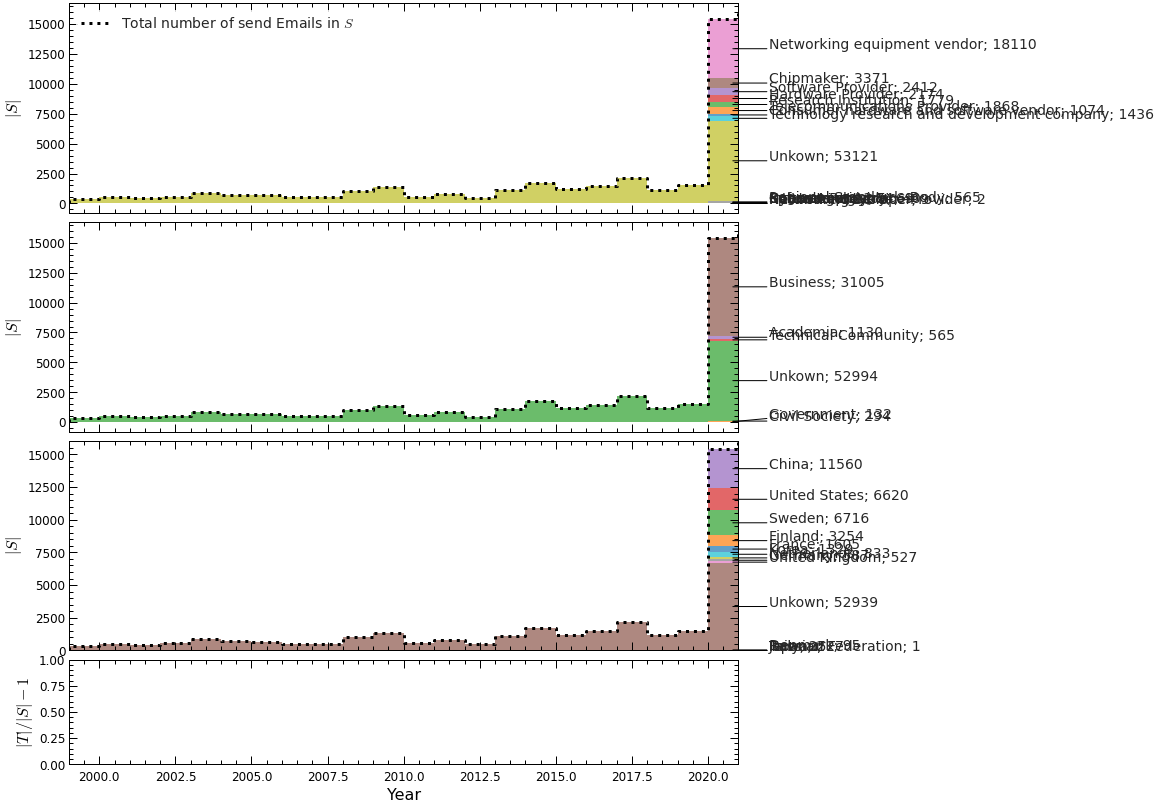

In [60]:
fig, axis = plt.subplots(
    4, 1,
    figsize=(12, 14),
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios': [2, 2, 2, 1]},
    facecolor="w", edgecolor="k",
)
fig.subplots_adjust(
    hspace=0.05,
    wspace=0.0,
)

years = np.arange(year_of_first_msg, year_of_last_msg+1)
years = [yr for yr in years for i in range(2)]
sset_counts_total = np.zeros(len(np.arange(year_of_first_msg, year_of_last_msg+1)) * 2)
first = True
for cat, dic in results_cat.items():
    # doublicate everything
    counts = [0] + [c for c in list(dic.values()) for i in range(2)][:-1]
    
    axis[0].fill_between(
        years,
        sset_counts_total,
        sset_counts_total + counts,
        alpha=0.7,
    )
    
    arrow_x1 = np.max(years)
    arrow_x2 = np.max(years)+1
    
    arrow_y1 = [sset_counts_total[idx] + counts[idx]/2 for idx, year in enumerate(years) if year == arrow_x1][0]
    if first:
        arrow_y2 = arrow_y1
        first = False
    else:
        arrow_y2 = arrow_y1 #+ 100
    
    axis[0].text(arrow_x2, arrow_y2, f"{cat}; {np.sum(counts)}",)
    axis[0].annotate(
        '',
        xy=(arrow_x1-0.25, arrow_y1), xycoords='data',
        xytext=(arrow_x2, arrow_y2), textcoords='data',
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3"),
    )
    sset_counts_total += counts

sset_counts_total = np.zeros(len(np.arange(year_of_first_msg, year_of_last_msg+1)) * 2)
first = True
for shgr, dic in results_shgr.items():
    # doublicate everything
    counts = [0] + [c for c in list(dic.values()) for i in range(2)][:-1]
    
    axis[1].fill_between(
        years,
        sset_counts_total,
        sset_counts_total + counts,
        alpha=0.7,
    )
    
    arrow_x1 = np.max(years)
    arrow_x2 = np.max(years)+1
    
    arrow_y1 = [sset_counts_total[idx] + counts[idx]/2 for idx, year in enumerate(years) if year == arrow_x1][0]
    if first:
        arrow_y2 = arrow_y1 + 300
        first = False
    else:
        arrow_y2 = arrow_y1 #+ 100
    
    axis[1].text(arrow_x2, arrow_y2, f"{shgr}; {np.sum(counts)}",)
    axis[1].annotate(
        '',
        xy=(arrow_x1-0.25, arrow_y1), xycoords='data',
        xytext=(arrow_x2, arrow_y2), textcoords='data',
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3"),
    )
    sset_counts_total += counts

sset_counts_total = np.zeros(len(np.arange(year_of_first_msg, year_of_last_msg+1)) * 2)
first = True
for nation, dic in results_nat.items():
    # doublicate everything
    counts = [0] + [c for c in list(dic.values()) for i in range(2)][:-1]
    
    axis[2].fill_between(
        years,
        sset_counts_total,
        sset_counts_total + counts,
        alpha=0.7,
    )
    
    arrow_x1 = np.max(years)
    arrow_x2 = np.max(years)+1
    
    arrow_y1 = [sset_counts_total[idx] + counts[idx]/2 for idx, year in enumerate(years) if year == arrow_x1][0]
    if first:
        arrow_y2 = arrow_y1
        first = False
    else:
        arrow_y2 = arrow_y1 #+ 100
    
    axis[2].text(arrow_x2, arrow_y2, f"{nation}; {np.sum(counts)}",)
    axis[2].annotate(
        '',
        xy=(arrow_x1-0.25, arrow_y1), xycoords='data',
        xytext=(arrow_x2, arrow_y2), textcoords='data',
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3"),
    )
    sset_counts_total += counts

# axis[3].plot(
#     years,
#     tset_counts_total / sset_counts_total - 1,
#     linewidth=3,
#     linestyle='--',
#     color='k',
#     drawstyle='steps',
# )
# axis[3].hlines(
#     y=0,
#     xmin=year_of_first_msg,
#     xmax=year_of_last_msg,
#     linewidth=3,
#     linestyle='-',
#     color='k',
# )

for idx in range(len(axis)-1):
    axis[idx].plot(
        years,
        sset_counts_total,
        linewidth=3,
        linestyle=':',
        color='k',
        drawstyle='steps',
        label=r'Total number of send Emails in $S$',
    )
    axis[idx].set_ylabel(r'$|S|$')

for idx in range(len(axis)):
    axis[idx].set_xlim(year_of_first_msg, year_of_last_msg)
    
axis[2].set_ylim(0, np.max(sset_counts_total)+100)
axis[0].legend(
    loc=2,
    edgecolor='white',
    facecolor='white',
    framealpha=0.7,
    #ncol=3,
)

axis[3].set_xlabel('Year')
axis[3].set_ylabel(r'$|T| / |S| - 1$')

"""
plt.savefig(
    f"{mlist_name}_sset_hist_msgs.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

In [22]:
results = defaultdict(lambda: defaultdict(list))
for idx, row in mlist.df.iterrows():
    results[row['from_nationality']][row['date'].year].append(row['from'])
    
for nation, dic in results.items():
    for year, flist in dic.items():
        results[nation][year] = len(list(set(flist)))

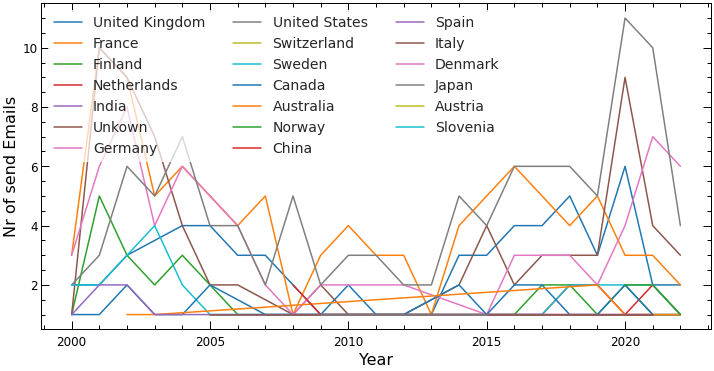

In [23]:
fig, axis = plt.subplots(
    1, 1,
    figsize=(12, 6),
    #sharex=True, sharey='row',
    #gridspec_kw={'height_ratios': [2, 1]},
    facecolor="w", edgecolor="k",
)

for nation, dic in results.items():
    axis.plot(
        dic.keys(),
        dic.values(),
        label=nation,
    )

axis.set_xlabel('Year')
axis.set_ylabel('Nr of send Emails')
axis.legend(
    loc=2,
    edgecolor='white',
    facecolor='white',
    framealpha=0.7,
    ncol=3,
)